<a href="https://colab.research.google.com/github/acedesci/scanalytics/blob/master/S06_Descriptive_Analytics/S06_LectureEx_Data_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# S6 - Descriptive Analytics - Clustering Models
Programming topics covered in this section:
* Data transformation for descriptive analytics
* Clustering and segmentation models
  *   K-Means clustering and optimization
  *   Hierarchical clustering



Examples include:
* Transportation shipment clustering analysis

In [2]:
import pandas as pd

## 1. Importing data and creating a report
In this exercise, we make use of supply chain health commodity shipment and pricing data.The data set provides the commodity pricing and associated supply chain expenses necessary to move the commodities to countries for use. The original data are provided by the US Agency for International Development and can be accessed at [this page](https://catalog.data.gov/dataset/supply-chain-shipment-pricing-data).

This is a description of our adapted data in the file `SCMS_Delivery_History_Dataset.csv`.

| VARIABLE NAME | DESCRIPTION | 
|:----|:----|
|id| identification number|
|project code|identification of the project|
|country|country to which the items are shipped|
|vendor|identification of the vendor of the item|
|manufacturing site|name of the manufacturer of the item|
|shipment mode|transportation mode (e.g., air, truck)|
|scheduled delivery date|programmed date for delivery|
|delivered to client date|real date of delivery|
|delivery recorded date|registered date of delivery|
|product group|main category of the item|
|product subgroup|subcategory of the item (e.g., HIV test, pediatric, Adult) |
|molecule type|description of the composition of the item (e.g., Nevirapine, HIV 1/2, Didanosine)|
|brand| item brand (e.g, generic or any other commercial brand)|
|dosage| specifications about the dosage of each item (e.g.,10mg/ml, 200mg)|
|dosage form|instructions for consumption (e.g., capsule, tablet, oral solution) |
|units per pack| number of units in each package|
|quantity pack sold| number of packages shipped to the specified country|
|value sold| total value in $\$$ USD of the shipment (i.e., pack_price * quantity pack sold|
|pack price| price in $\$$ USD per package|
|unit price| price in $\$$ USD per unit|
|weight (kilograms)| total weight in kilograms of the shipment|
|freight cost (usd)| value in $\$$USD paid for transportation|
|insurance (usd)|value in $\$$USD paid for insurance|

Similar to session 5, we will import the data, transform the columns which contain dates and numerical values to their corresponding format. 

In [3]:
url = 'https://raw.githubusercontent.com/acedesci/scanalytics/master/S05_Data_Preprocessing/Supply_Chain_Shipment_Pricing_Data.csv'
df_SC = pd.read_csv(url)  # reading data file into a DataFrame

df_SC.columns = df_SC.columns.str.replace(' ', '_')
df_SC.columns = df_SC.columns.str.replace('(', '')
df_SC.columns = df_SC.columns.str.replace(')', '')
df_SC.columns = df_SC.columns.str.replace('#', '')
df_SC.columns = df_SC.columns.str.replace('/', '')

# transform date and numerical data
df_SC['pq_first_sent_to_client_date'] = pd.to_datetime(df_SC['pq_first_sent_to_client_date'], errors='coerce')
df_SC['scheduled_delivery_date'] = pd.to_datetime(df_SC['scheduled_delivery_date'], errors='coerce')
df_SC['delivered_to_client_date'] = pd.to_datetime(df_SC['delivered_to_client_date'], errors='coerce')
df_SC['weight_kilograms'] = pd.to_numeric(df_SC['weight_kilograms'], errors='coerce')
df_SC['freight_cost_usd'] = pd.to_numeric(df_SC['freight_cost_usd'], errors='coerce')




For this analysis, we will also choose only data after 2010 and non-missing ones for the analysis. The only data will will use are the columns ` ['country', 'line_item_value','weight_kilograms','freight_cost_usd']`

In [4]:
# choose only non-missing data and data after 2010
df_SC = df_SC[(df_SC['freight_cost_usd'].notna()) & df_SC['weight_kilograms'] & (df_SC['delivered_to_client_date'] >= '2010-01-01')]

selected_columns = ['country', 'line_item_value','weight_kilograms','freight_cost_usd']
print(df_SC.isna().sum())

id                                0
project_code                      0
pq_                               0
po__so_                           0
asndn_                            0
country                           0
managed_by                        0
fulfill_via                       0
vendor_inco_term                  0
shipment_mode                     0
pq_first_sent_to_client_date      5
po_sent_to_vendor_date            0
scheduled_delivery_date           0
delivered_to_client_date          0
delivery_recorded_date            0
product_group                     0
sub_classification                0
vendor                            0
item_description                  0
moleculetest_type                 0
brand                             0
dosage                          906
dosage_form                       0
unit_of_measure_per_pack          0
line_item_quantity                0
line_item_value                   0
pack_price                        0
unit_price                  

Since the clustering analysis will be perform at the country level, we will use the function groupby to prepare the input. The function `df.groupby(...).agg(...)` allows us to aggregate each column differently based on what specified in the dictionary. You can review more details here: [link1](https://pandas.pydata.org/pandas-docs/version/0.23/generated/pandas.core.groupby.DataFrameGroupBy.agg.html) and here [link2](https://pbpython.com/groupby-agg.html).

In [5]:
df_SC_selected = df_SC[selected_columns].groupby(['country']).agg({'line_item_value':'sum','weight_kilograms':'mean','freight_cost_usd':'mean'})


Since clustering algorithms are typically highly influenced by scale (e.g. not scale-invariant), one common practice is to normalize the data before use. We opt for `z-score` normalization. We also keep the list of column names containing normal values and normalized values to make it easier when making a reference.

In [6]:
for col in df_SC_selected.columns:
    df_SC_selected['z_'+col] = (df_SC_selected[col] - df_SC_selected[col].mean())/df_SC_selected[col].std()

normal_columns = list(df_SC_selected.columns[:3])
z_columns = list(df_SC_selected.columns[3:])

Now we can explore the data using the pairwise plot in seaborn.  

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


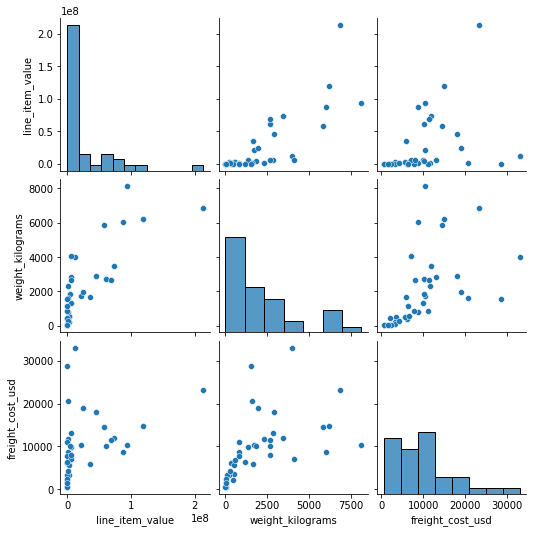

In [8]:
import seaborn as sns
sns.pairplot(data=df_SC_selected[normal_columns], size=2.5, palette = 'deep')

## Model 1: K-Means clustering

We first apply K-Means clutering algorithm using the commonly used package `scikit-learn`. The function `sklearn.cluster.KMeans(...)` return an object which gives multiple outputs (link provided below). The main output is `.labels_` (note that this is a specific attribute name provided by the method) which returns the list containing the cluster label of all the data points. In order to learn/determine the labels from the data, we also need to call `.fit(X)` to pass the input variables `X` (our z-score normalized variables) to the method.

[link to description](https://scikit-learn.org/stable/modules/clustering.html#k-means) and [link to KMeans function](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans)


In [25]:
import matplotlib.pyplot as plt
import sklearn
from sklearn.cluster import KMeans, AgglomerativeClustering

# K-Means clustering

# first select only the variables which we want to use for clustering
X = df_SC_selected[z_columns]

# create a K-Means object using the number of clusters = 3 and fit to the data
# note that K-Means algorithm is initiated using a randomized process, 
# thus we indicate `random_state=0` to fix the random seed to make sure the same result is returned every time we run
kmeans_object = sklearn.cluster.KMeans(n_clusters=3, random_state=0).fit(X)

# now we obtain the list of cluster labels and add it to the original DataFrame
# note that the label ID might change in a different run but the cluster remains the same if the seed is the same  
# (e.g., data point 1 has label 0 in the first time we run but then label 2 in another run but still belongs to the same data cluster)  
df_SC_selected['K3_cluster'] = kmeans_object.labels_
df_SC_selected.tail()


,line_item_value,weight_kilograms,freight_cost_usd,z_line_item_value,z_weight_kilograms,z_freight_cost_usd,K3_cluster
country,,,,,,,
Togo,1.532580e+05,1162.500000,6272.360000,-0.557704,-0.433224,-0.485487,1
Uganda,6.803387e+07,2682.802273,11508.059523,0.958004,0.279221,0.212985,2
Vietnam,3.503135e+07,1652.715190,5915.752468,0.221090,-0.203499,-0.533060,1
Zambia,1.195445e+08,6204.486755,14856.484636,2.108185,1.929554,0.659683,0
Zimbabwe,5.799046e+07,5837.093023,14452.896240,0.733744,1.757385,0.605842,0


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


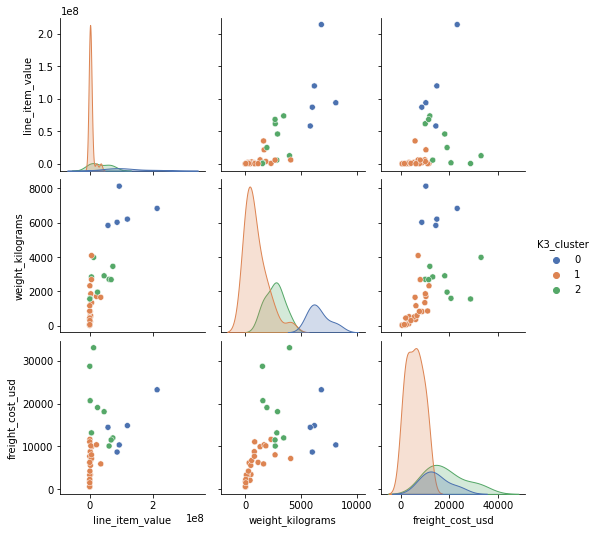

In [27]:
import seaborn as sns
sns.pairplot(data=df_SC_selected[normal_columns+["K3_cluster"]], hue='K3_cluster', size=2.5, palette = 'deep')



In order to choose the optimal number of clusters (in case it is not predefined), we can compare the results based on a different number of 


*   **Inertia** or sum-of-square (SSE) within the cluster: This one measure the compactness of each cluster. It is the objective function that the standard K-Means algorithm optimizes (see [link](https://scikit-learn.org/stable/modules/clustering.html)). This can be obtained through the attribute `.inertia_` from the K-Means object. 
*   **Silhouette** value: This one represents how well the clusters are separated from each others (ee [link](https://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient)). This can be done through the method `sklearn.metrics.silhouette_score(X, cluster_labels)`.

In practice, a lower number of clusters is typically preferred so we choose the number of clusters where significant improvements are observed in both measures among reasonable choices of $k$.


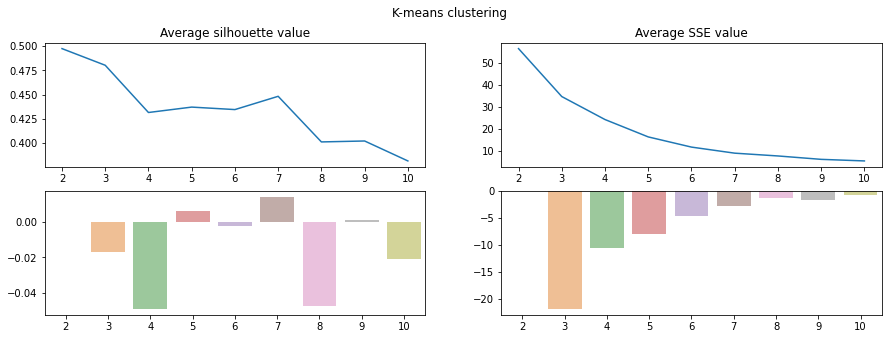

In [28]:
from sklearn.metrics import silhouette_score

# list the acceptable range of the number of clusters to explore
kmeans_range = list(range(2,11))

# prepare empty lists to store the inertia and silhouette values
inertia_list = []
silhouette_list = []

for k in kmeans_range:
  # fit the clustering algorithm
  kmeans_object = sklearn.cluster.KMeans(n_clusters=k, random_state=0).fit(X)

  # obtain the inertia and add the result to the list
  inertia_list.append(kmeans_object.inertia_)

  # calculate the silhouette score by providing data X and labels, then add the result to the list
  silhouette_val = sklearn.metrics.silhouette_score(X, kmeans_object.labels_)
  silhouette_list.append(silhouette_val)


# calculate the marginal difference of silhouette for each step of k
diff_silhouette = [silhouette_list[i] - silhouette_list[max(0,i-1)] for i in range(len(kmeans_range))]
# calculate the marginal difference of inertia for each step of k
diff_inertia = [inertia_list[i] - inertia_list[max(0,i-1)] for i in range(len(kmeans_range))]

# Plot the results using seaborn using a grid of 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 5))
fig.suptitle('K-means clustering')

sns.lineplot(ax=axes[0,0], x=kmeans_range, y=silhouette_list).set_title('Average silhouette value')
sns.lineplot(ax=axes[0,1], x=kmeans_range, y=inertia_list).set_title('Average SSE value')
sns.barplot(ax=axes[1,0], x=kmeans_range, y=diff_silhouette, alpha=0.5)
sns.barplot(ax=axes[1,1], x=kmeans_range, y=diff_inertia, alpha=0.5)


## Model 2: Hierarchical clustering

In some cases, we must create a hierarchy of the clusters/groups rather than just a single level cluster to allow different levels of aggregation and disaggregation (e.g., product/customer hierarchy). One of the commonly used methods is Agglomerative Clustering which can be used to ensure this hierarchical consistency of the clusters.

[link to description](https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering) and [link to the function](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)

Here we will demonstrate the concept by showing the results based on the number of clusters $k=2, 3, 4$. The default version of this method optimizes the within-cluster sum of squares which is the same objective as in the standard K-Means (but other objectives are available as described in the link).

In [32]:
hcluster = sklearn.cluster.AgglomerativeClustering(n_clusters=4).fit(X)
hcluster.n_leaves_

38

In [29]:
# Hierarchical clustering
hcluster2 = sklearn.cluster.AgglomerativeClustering(n_clusters=2).fit(X)
df_SC_selected['A2_cluster'] = hcluster2.labels_

# print out the number of countries under each cluster
print(df_SC_selected['A2_cluster'].value_counts())

hcluster3 = sklearn.cluster.AgglomerativeClustering(n_clusters=3).fit(X)
df_SC_selected['A3_cluster'] = hcluster3.labels_

# print out the number of countries under each cluster
print(df_SC_selected['A3_cluster'].value_counts())

hcluster4 = sklearn.cluster.AgglomerativeClustering(n_clusters=4).fit(X)
df_SC_selected['A4_cluster'] = hcluster4.labels_

# print out the number of countries under each cluster
print(df_SC_selected['A4_cluster'].value_counts())

df_SC_selected

0    33
1     5
Name: A2_cluster, dtype: int64
2    17
0    16
1     5
Name: A3_cluster, dtype: int64
2    17
1    11
3     5
0     5
Name: A4_cluster, dtype: int64


,line_item_value,weight_kilograms,freight_cost_usd,z_line_item_value,z_weight_kilograms,z_freight_cost_usd,K3_cluster,A2_cluster,A3_cluster,A4_cluster
country,,,,,,,,,,
Afghanistan,1.736000e+03,44.500000,540.525000,-0.561087,-0.957141,-1.250145,1,0,2,2
Angola,1.816000e+05,362.200000,6166.414000,-0.557071,-0.808260,-0.499620,1,0,2,2
Benin,5.454805e+05,2323.600000,11638.258000,-0.548946,0.110891,0.230354,1,0,0,1
Botswana,1.303711e+06,525.766667,3451.025333,-0.532016,-0.731610,-0.861868,1,0,2,2
Burundi,2.277174e+06,512.750000,5572.184286,-0.510279,-0.737710,-0.578894,1,0,2,2
Cameroon,1.234366e+07,3977.666667,33026.949815,-0.285504,0.886021,3.083723,2,0,0,3
"Congo, DRC",2.777920e+06,592.355769,6721.951058,-0.499098,-0.700405,-0.425509,1,0,2,2
Côte d'Ivoire,6.147014e+07,2699.873118,10091.968387,0.811442,0.287221,0.024070,2,0,0,1
Dominican Republic,1.558134e+06,824.892857,8780.877857,-0.526335,-0.591433,-0.150836,1,0,2,2


Now we plot the clusters using seaborn scatter plots.

Text(0.5, 1.0, 'A4_cluster')

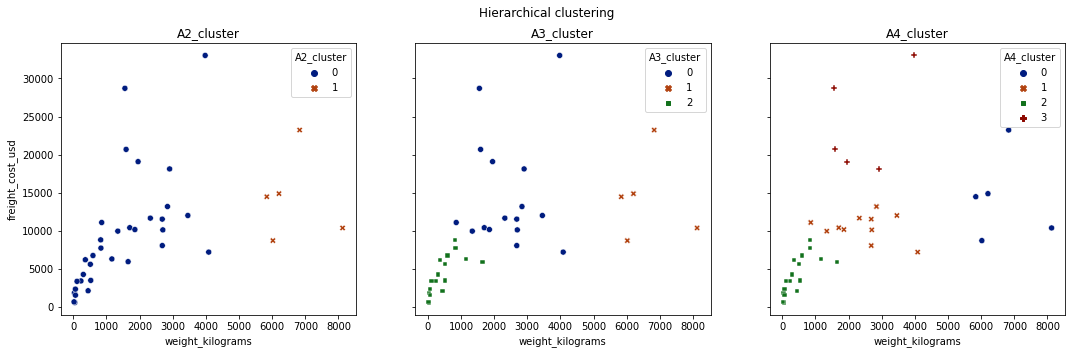

In [30]:
from matplotlib import pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 5),sharey=True)
fig.suptitle('Hierarchical clustering')

# 2 clusters
sns.scatterplot(data = df_SC_selected, ax=axes[0], x=normal_columns[1], y=normal_columns[2], hue='A2_cluster', style='A2_cluster', palette='dark')
axes[0].set_title('A2_cluster')

# 3 clusters
sns.scatterplot(data = df_SC_selected, ax=axes[1], x=normal_columns[1], y=normal_columns[2], hue='A3_cluster', style='A3_cluster', palette='dark')
axes[1].set_title('A3_cluster')

# 4 clusters
sns.scatterplot(data = df_SC_selected, ax=axes[2], x=normal_columns[1], y=normal_columns[2], hue='A4_cluster', style='A4_cluster', palette='dark')
axes[2].set_title('A4_cluster')